In [17]:
import numpy as np
from PIL import Image
import random, itertools
import time, os
import matplotlib.pyplot as plt

In [18]:
SboxFile = "sbox_08x08.sbx"
PathInput = "img/1.input/"
PathEnc = "img/2.encryption/"
PathDec = "img/3.decryption/"

In [19]:
def createSboxMatrix(contentInfo: str) -> np.array:
    with open(contentInfo, mode='rb') as file: 
        fileContent = file.read()
    
    resultTab = np.array([], dtype=np.int32)
    for i in range(0, len(fileContent), 2):
        resultTab = np.append(resultTab, [np.array(fileContent[i])], axis=0)

    return resultTab

SboxArray = createSboxMatrix(SboxFile)

def imgEncryptSbox(input, output, mode, isSimple=True, format="BMP"): # if mode == True then Encrypt
    random.seed(42)
    image = np.array(Image.open(input))

    for row, col, channel in itertools.product(*[range(sh) for sh in image.shape]):
        chValue = image[row, col, channel]
        randomInt = 0 if isSimple else random.randint(0, 255)

        image[row, col, channel] = (SboxArray[chValue] ^ randomInt) if mode else np.where(SboxArray == (chValue ^ randomInt))[0]

    Image.fromarray(image).save(output, format=format)

In [20]:
def imgEncryptArnold(input, output, mode, format="BMP"): # if mode == True then Encrypt
    image = np.array(Image.open(input))
    N = image.shape[0]
    
    if N != image.shape[1]:
        print(f"Image {input} should be sqare!")
        return
    
    x, y = np.meshgrid(range(N), range(N))
    xmap = (x + 3*y) % N
    ymap = (2*x + 5*y) % N

    if not mode: # Decryption - calculations of inversed xmap and ymap
        inv_xmap = np.zeros_like(xmap)
        inv_ymap = np.zeros_like(ymap)

        for i, j in itertools.product(*[range(N), range(N)]):
            inv_xmap[xmap[i,j], ymap[i,j]] = i
            inv_ymap[xmap[i,j], ymap[i,j]] = j

        xmap = inv_xmap
        ymap = inv_ymap

    for _ in range(15):
        image = image[xmap, ymap]
    
    Image.fromarray(image).save(output, format=format)


In [21]:
imagesToEncrypt = os.listdir(PathInput)

encryptSboxTimes = []
decryptSboxTimes = []
encryptArnoldTimes = []
decryptArnoldTimes = []

for img in imagesToEncrypt:
    start_time = time.time()
    imgEncryptSbox(PathInput + img, PathEnc + "sb_" + img, True, False)
    encryptSboxTimes.append(time.time() - start_time)

    start_time = time.time()
    imgEncryptSbox(PathEnc + "sb_" + img, PathDec + "sb_" + img, False, False)
    decryptSboxTimes.append(time.time() - start_time)

    start_time = time.time()
    imgEncryptArnold(PathInput + img, PathEnc + "ar_" + img, True)
    encryptArnoldTimes.append(time.time() - start_time)

    start_time = time.time()
    imgEncryptArnold(PathEnc + "ar_" + img, PathDec + "ar_" + img, False)
    decryptArnoldTimes.append(time.time() - start_time)

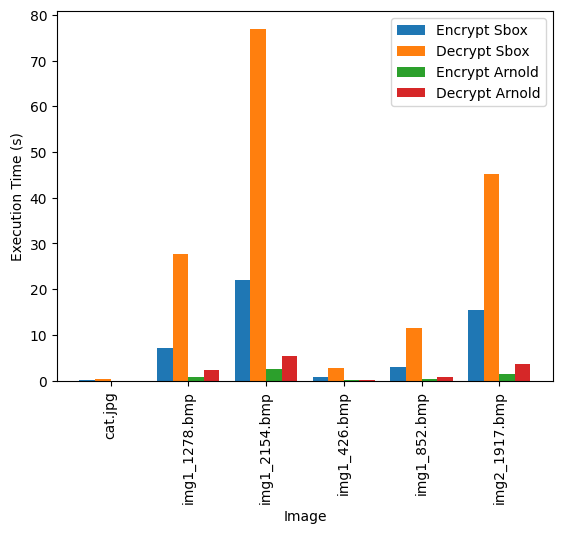

In [22]:
bar_width = 0.2

plt.bar(range(len(imagesToEncrypt)), encryptSboxTimes, width=bar_width, label='Encrypt Sbox')
plt.bar([i + bar_width for i in range(len(imagesToEncrypt))], decryptSboxTimes, width=bar_width, label='Decrypt Sbox')
plt.bar([i + 2*bar_width for i in range(len(imagesToEncrypt))], encryptArnoldTimes, width=bar_width, label='Encrypt Arnold')
plt.bar([i + 3*bar_width for i in range(len(imagesToEncrypt))], decryptArnoldTimes, width=bar_width, label='Decrypt Arnold')
plt.xticks([i + 1.5*bar_width for i in range(len(imagesToEncrypt))], imagesToEncrypt, rotation=90)
plt.xlabel('Image')
plt.ylabel('Execution Time (s)')
plt.legend()
plt.show()

In [23]:
results =  np.round(np.array([encryptSboxTimes, decryptSboxTimes, encryptArnoldTimes, decryptArnoldTimes]), 3).astype(str)
np.set_printoptions(precision=3, suppress=True)

results = np.insert(results, 0, imagesToEncrypt, axis=0)

print(results)

[['cat.jpg' 'img1_1278.bmp' 'img1_2154.bmp' 'img1_426.bmp' 'img1_852.bmp'
  'img2_1917.bmp']
 ['0.1' '7.088' '21.996' '0.845' '3.009' '15.439']
 ['0.31' '27.791' '76.95' '2.85' '11.619' '45.295']
 ['0.01' '0.808' '2.521' '0.071' '0.347' '1.402']
 ['0.028' '2.248' '5.377' '0.193' '0.87' '3.63']]
